# Sigmoid激活函数

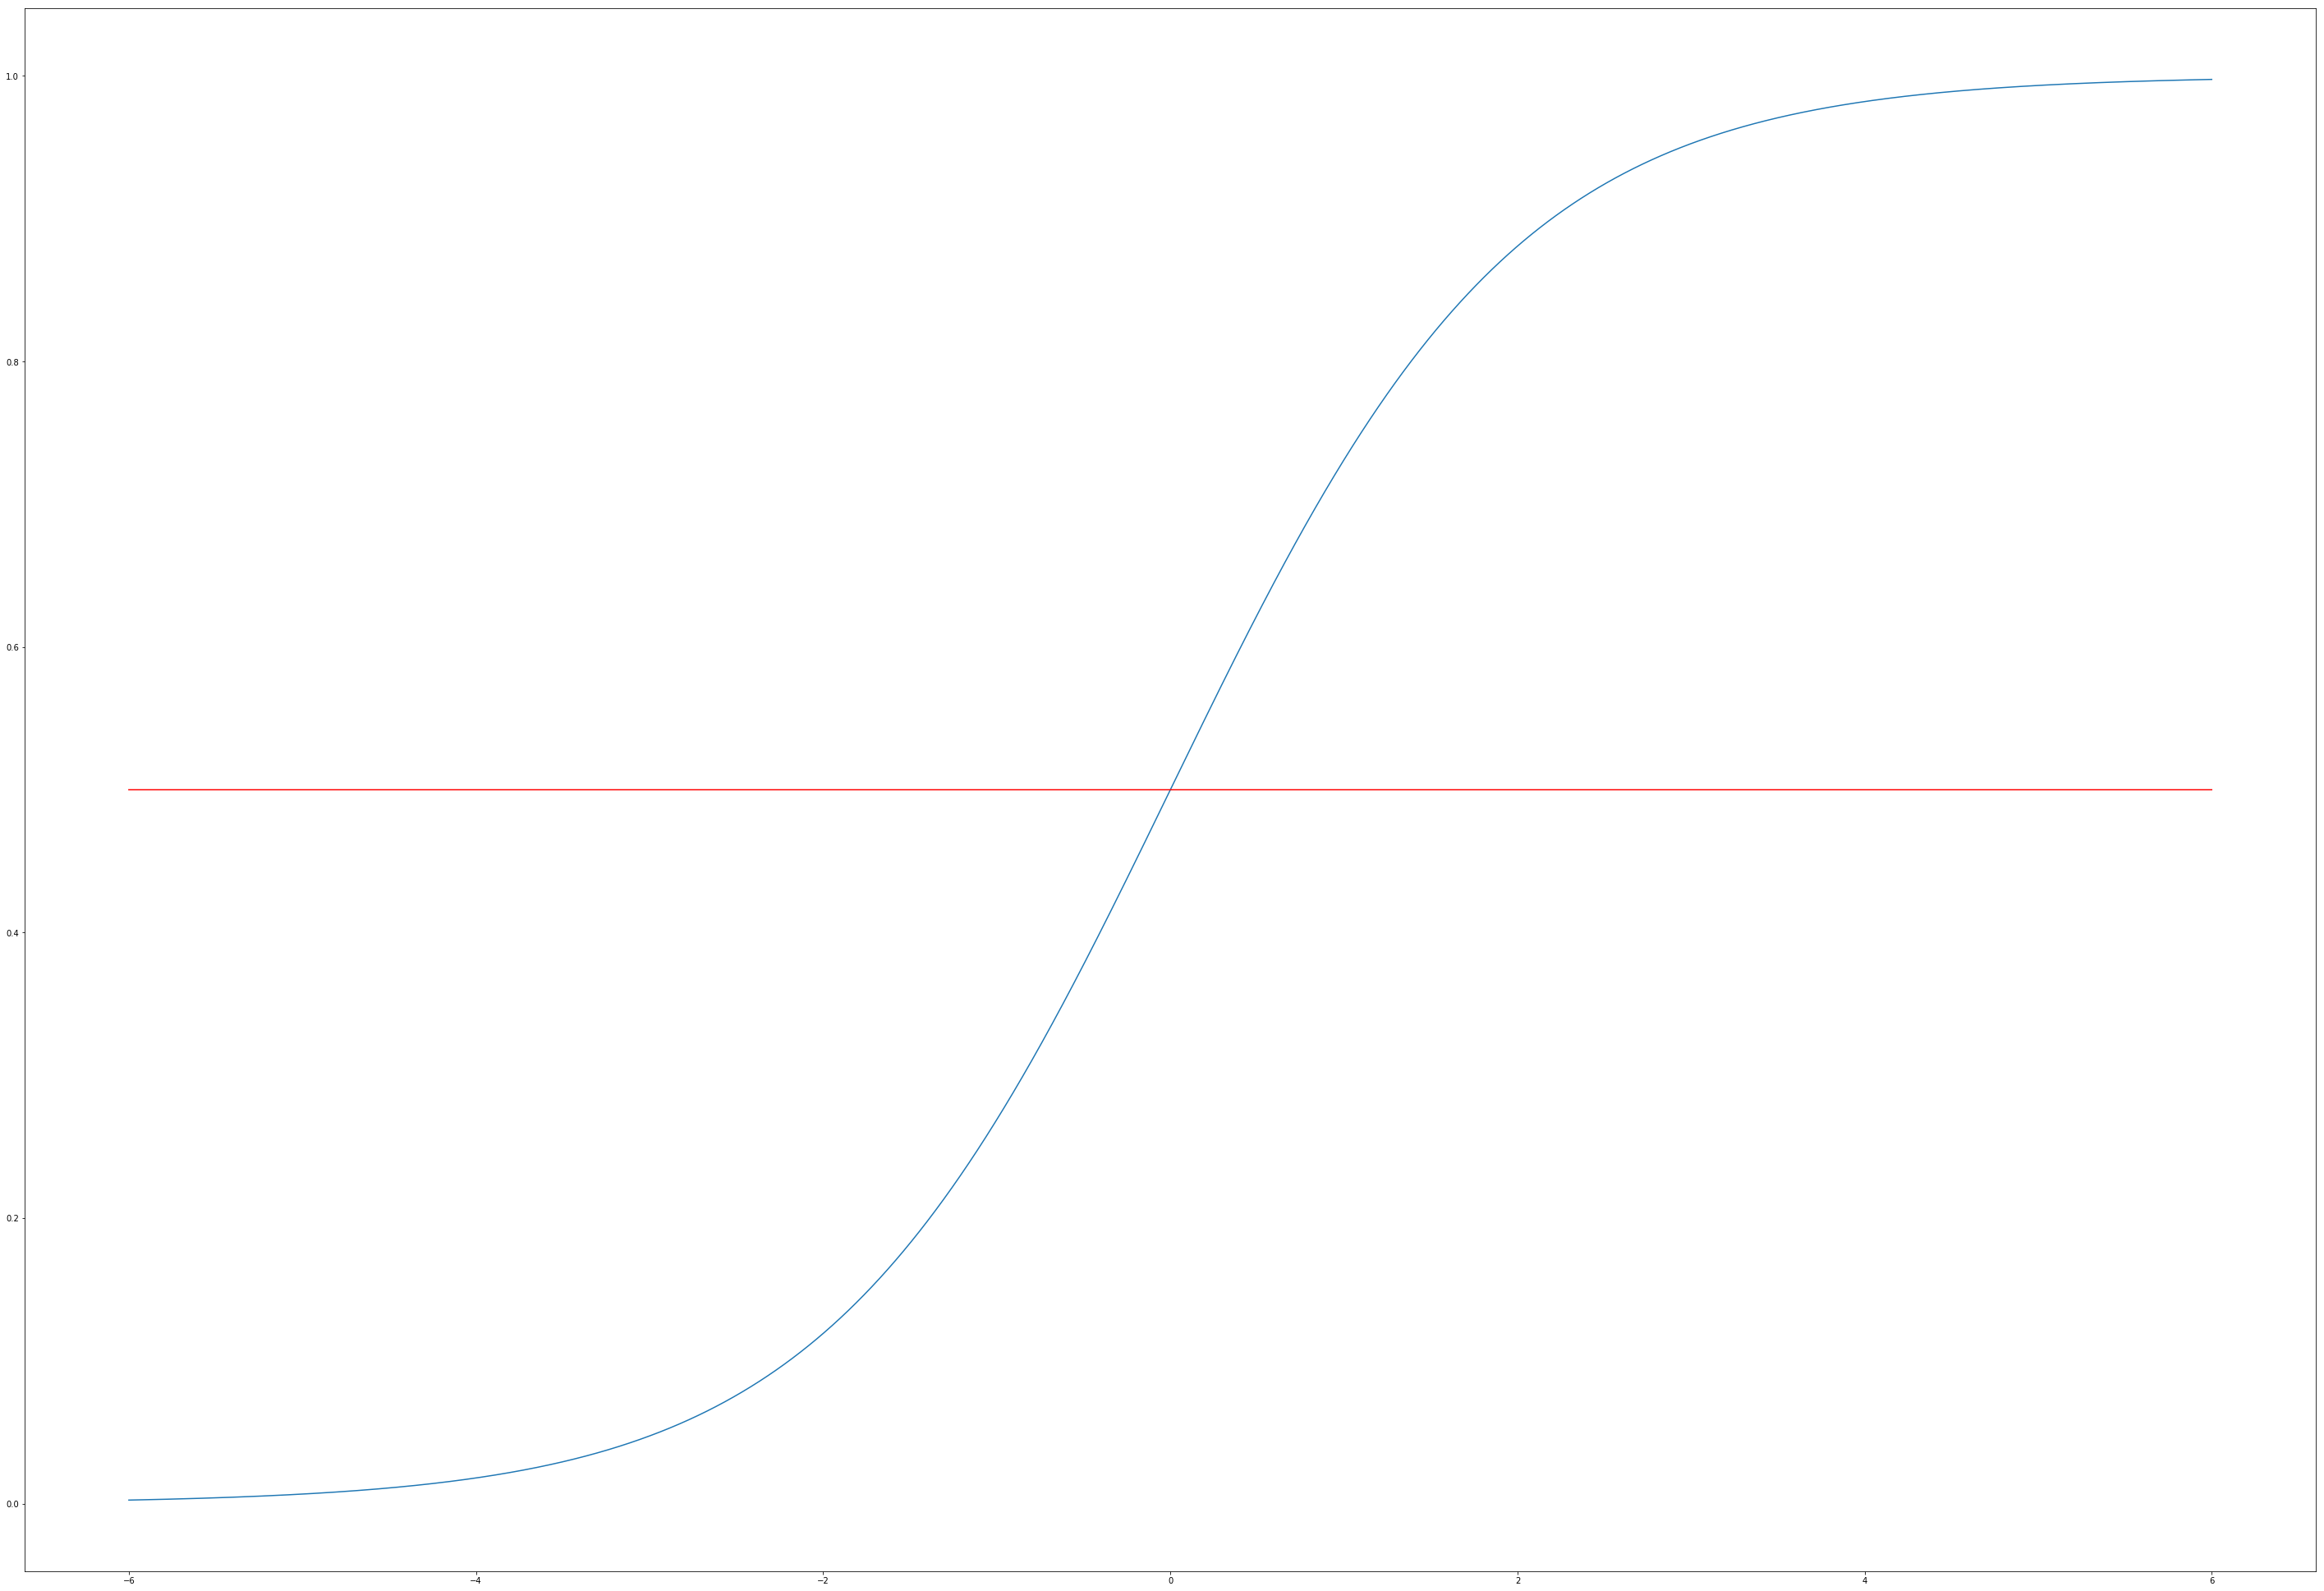

In [1]:
import math
def sigmoid(x):
    return 1 / (1 + math.exp(-x))
import numpy as np
x = np.arange(-6, 6, 0.001)
y = np.array([sigmoid(xx) for xx in x])

from matplotlib import pyplot as plt
%matplotlib inline
plt.figure(figsize=(50, 35))
plt.plot(x, y)
plt.plot(x, np.zeros(x.shape) + 0.5, color='r')

# 识别验证码

## 创建数据集

In [1]:
import numpy as np
from PIL import Image, ImageDraw, ImageFont
from skimage import transform as tf

In [47]:
def create_captcha(text, shear=0, size=(100,24)):
    im = Image.new("L", size, "black")
    draw = ImageDraw.Draw(im)
    font = ImageFont.truetype(r"./data/Coval-Book.otf", 22)
    draw.text((0, 0), text, fill=1, font=font)
    image = np.array(im)
    affine_tf = tf.AffineTransform(shear=shear)
    image = tf.warp(image, affine_tf)
    return image / image.max()

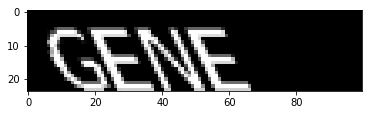

In [48]:
%matplotlib inline
from matplotlib import pyplot as plt
image = create_captcha("GENE", shear=0.5)
plt.imshow(image, cmap="gray")

In [49]:
from skimage.measure import label, regionprops

def segment_image(image):
    labeled_image = label(image > 0)
    subimages = []
    for region in regionprops(labeled_image):
        start_x, start_y, end_x, end_y = region.bbox
        subimages.append(image[start_x:end_x, start_y:end_y])
    if len(subimages) == 0:
        return [image,]
    return subimages

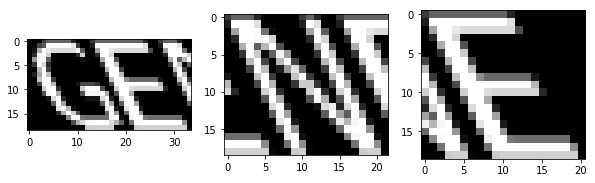

In [50]:
subimages = segment_image(image)
f, axes = plt.subplots(1, len(subimages), figsize=(10, 3))
for i in range(len(subimages)):
    axes[i].imshow(subimages[i], cmap="gray")

In [51]:
from sklearn.utils import check_random_state
random_state = check_random_state(14)
letters = list("ACBDEFGHIJKLMNOPQRSTUVWXYZ")
shear_values = np.arange(0, 0.5, 0.05)

In [53]:
def generate_sample(random_state=None):
    random_state = check_random_state(random_state)
    letter = random_state.choice(letters)
    shear = random_state.choice(shear_values)
    return create_captcha(letter, shear=shear, size=(20, 20)), letters.index(letter)

The target for this image is: 11


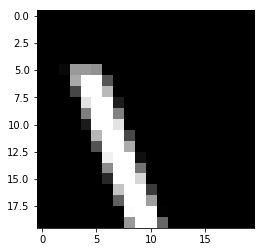

In [54]:
image, target = generate_sample(random_state)
plt.imshow(image, cmap="gray")
print("The target for this image is: {0}".format(target))

In [55]:
dataset, targets = zip(*(generate_sample(random_state) for i in
range(3000)))
dataset = np.array(dataset, dtype='float')
targets = np.array(targets)

In [56]:
from sklearn.preprocessing import OneHotEncoder
onehot = OneHotEncoder()
y = onehot.fit_transform(targets.reshape(targets.shape[0],1))

In [57]:
y = y.todense()

In [58]:
from skimage.transform import resize

In [59]:
dataset = np.array([resize(segment_image(sample)[0], (20, 20)) for
sample in dataset])

/home/dlinking-lxy/more-space/pyworks/venv/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [60]:
X = dataset.reshape((dataset.shape[0], dataset.shape[1] *
dataset.shape[2]))

In [61]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9)

## 训练和分类
安装pybrain包务必用以下方法
```
pip install https://github.com/pybrain/pybrain/archive/0.3.3.zip
```

In [63]:
from pybrain.datasets import SupervisedDataSet

In [64]:
training = SupervisedDataSet(X.shape[1], y.shape[1])
for i in range(X_train.shape[0]):
    training.addSample(X_train[i], y_train[i])

In [65]:
testing = SupervisedDataSet(X.shape[1], y.shape[1])
for i in range(X_test.shape[0]):
    testing.addSample(X_test[i], y_test[i])

In [66]:
from pybrain.tools.shortcuts import buildNetwork
net = buildNetwork(X.shape[1], 100, y.shape[1], bias=True)

In [67]:
from pybrain.supervised.trainers import BackpropTrainer
trainer = BackpropTrainer(net, training, learningrate=0.01,
weightdecay=0.01)

In [68]:
trainer.trainEpochs(epochs=20)

In [69]:
predictions = trainer.testOnClassData(dataset=testing)

In [77]:
from sklearn.metrics import f1_score
print("F-score: {0:.2f}".format(f1_score(predictions, y_test.argmax(axis=1),average='micro')))

F-score: 0.86


In [78]:
from sklearn.metrics import classification_report
print(classification_report(y_test.argmax(axis=1), predictions))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        10
          1       1.00      0.91      0.95        11
          2       1.00      1.00      1.00        11
          3       1.00      1.00      1.00        12
          4       1.00      0.33      0.50        15
          5       0.47      1.00      0.64         9
          6       1.00      1.00      1.00        10
          7       0.93      1.00      0.96        13
          8       0.43      1.00      0.61        10
          9       1.00      0.46      0.63        13
         10       1.00      1.00      1.00         8
         11       0.53      0.67      0.59        12
         12       0.90      1.00      0.95         9
         13       1.00      1.00      1.00        15
         14       0.47      1.00      0.64         9
         15       1.00      1.00      1.00        14
         16       0.00      0.00      0.00         7
         17       1.00      1.00      1.00   

/home/dlinking-lxy/more-space/pyworks/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [80]:
def predict_captcha(captcha_image, neural_network):
    subimages = segment_image(captcha_image)
    predicted_word = ""
    for subimage in subimages:
        subimage = resize(subimage, (20, 20))
        outputs = net.activate(subimage.flatten())
        prediction = np.argmax(outputs)
        predicted_word += letters[prediction]
    return predicted_word

In [81]:
word = "GENE"
captcha = create_captcha(word, shear=0.2)
print(predict_captcha(captcha, net))

TNR


/home/dlinking-lxy/more-space/pyworks/venv/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [84]:
def test_prediction(word, net, shear=0.2):
    captcha = create_captcha(word, shear=shear)
    prediction = predict_captcha(captcha, net)
    prediction = prediction[:4]
    return word == prediction, word, prediction

In [88]:
from nltk.corpus import words
valid_words = [word.upper() for word in words.words() if len(word) == 4]


```python
LookupError: 
**********************************************************************
  Resource words not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('words')
  
  Searched in:
    - '/home/dlinking-lxy/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
    - '/home/dlinking-lxy/more-space/pyworks/venv/nltk_data'
    - '/home/dlinking-lxy/more-space/pyworks/venv/lib/nltk_data'
**********************************************************************
```
如果出现以上错误，运行
```python
import nltk
nltk.download('words')
```

In [90]:
num_correct = 0
num_incorrect = 0
for word in valid_words:
    correct, word, prediction = test_prediction(word, net, shear=0.2)
    if correct:
        num_correct += 1
    else:
        num_incorrect += 1

/home/dlinking-lxy/more-space/pyworks/venv/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [91]:
print("Number correct is {0}".format(num_correct))
print("Number incorrect is {0}".format(num_incorrect))

Number correct is 153
Number incorrect is 5360


In [92]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), predictions)

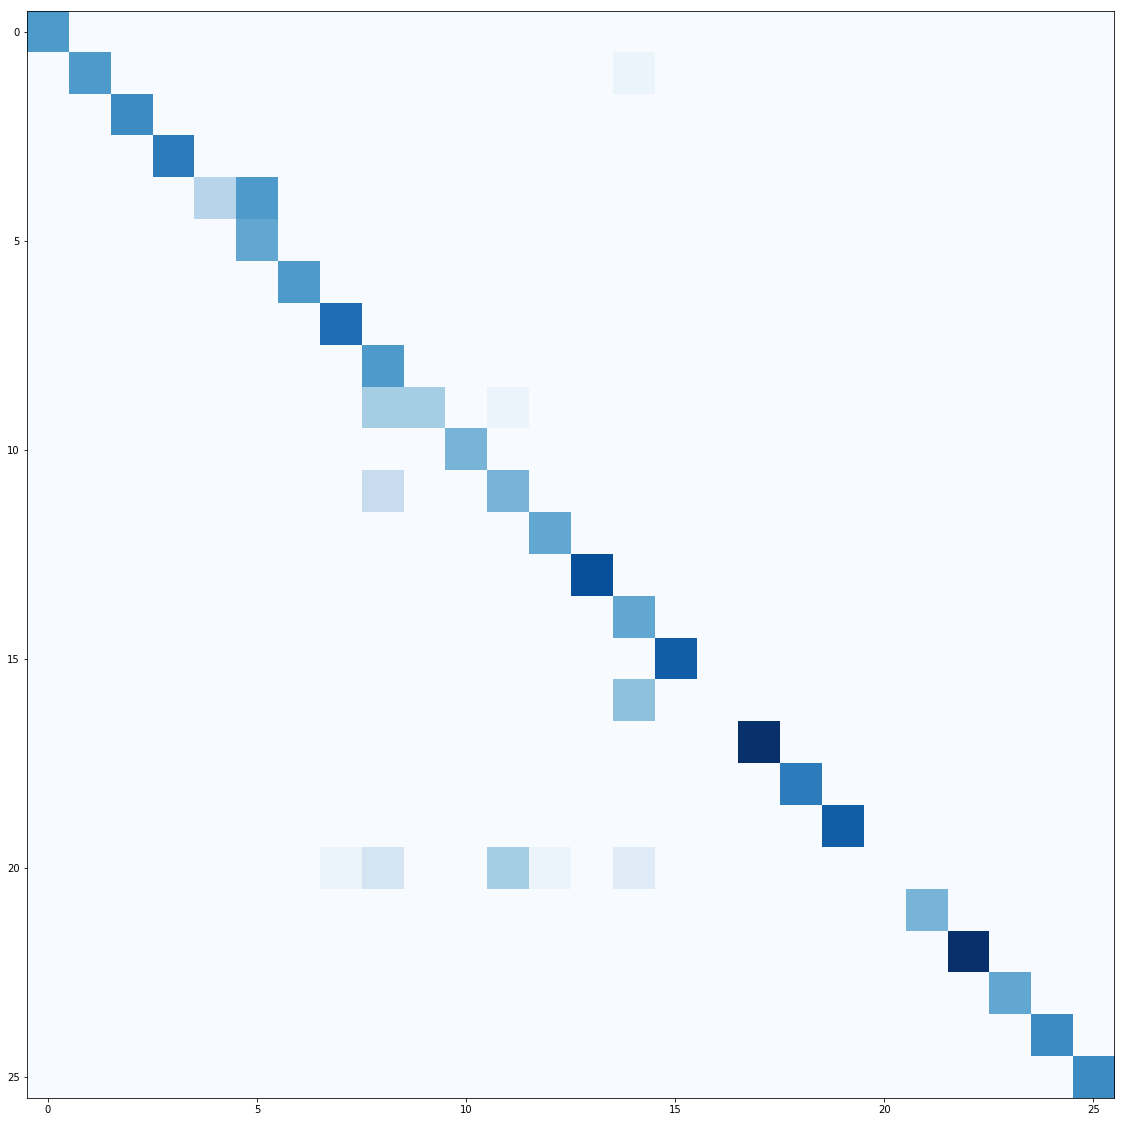

In [93]:
plt.figure(figsize=(20,20))
plt.imshow(cm, cmap="Blues")

## 用字典提升正确率

In [94]:
from nltk.metrics import edit_distance
steps = edit_distance("STEP", "STOP")
print("The number of steps needed is: {0}".format(steps))

The number of steps needed is: 1


In [95]:
def compute_distance(prediction, word):
    return len(prediction) - sum(prediction[i] == word[i] for i in range(len(prediction)))

In [96]:
from operator import itemgetter
def improved_prediction(word, net, dictionary, shear=0.2):
    captcha = create_captcha(word, shear=shear)
    prediction = predict_captcha(captcha, net)
    prediction = prediction[:4]
    if prediction not in dictionary:
        distances = sorted([(word, compute_distance(prediction, word))
                            for word in dictionary],
                           key=itemgetter(1))
        best_word = distances[0]
        prediction = best_word[0]
    return word == prediction, word, prediction

In [97]:
num_correct = 0
num_incorrect = 0
for word in valid_words:
    correct, word, prediction = improved_prediction (word, net, valid_words, shear=0.2)
    if correct:
        num_correct += 1
    else:
        num_incorrect += 1
print("Number correct is {0}".format(num_correct))
print("Number incorrect is {0}".format(num_incorrect))

/home/dlinking-lxy/more-space/pyworks/venv/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Number correct is 284
Number incorrect is 5229
